In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from xgboost import XGBClassifier, XGBRegressor
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from statsmodels.stats.outliers_influence import variance_inflation_factor

class MachineLearning:
    
    def CompareClassifiers(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        n = len(np.unique(y))
        if n == 2:
            methods = [KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(),
                       AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), LogisticRegression(),
                       SVC()]
            strs = ['KNN', 'NB', 'DT', 'RF', 'AB', 'GB', 'XGB', 'Log', 'SVM']
        else:
            methods = [KNeighborsClassifier(), MultinomialNB(), DecisionTreeClassifier(), RandomForestClassifier(),
                       AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), SVC()]
            strs = ['KNN', 'NB', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        train_acc = []
        test_acc = []
        for i in range(len(methods)):
            clf = methods[i].fit(X_train, y_train)
            train_acc.append(clf.score(X_train, y_train))
            test_acc.append(clf.score(X_test, y_test))
        c1 = pd.DataFrame(strs)
        c2 = pd.DataFrame(train_acc)
        c3 = pd.DataFrame(test_acc)
        results = pd.concat([c1, c2, c3], axis='columns')
        results.columns = ['Model', 'train_acc', 'test_acc']
        return results
    
    def CompareRegressors(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        n = len(np.unique(y))
        methods = [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),
                       AdaBoostRegressor(), GradientBoostingRegressor(), XGBRegressor(), SVR()]
        strs = ['Lin', 'KNN', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        train_acc = []
        test_acc = []
        for i in range(len(methods)):
            reg = methods[i].fit(X_train, y_train)
            train_acc.append(reg.score(X_train, y_train))
            test_acc.append(reg.score(X_test, y_test))
        c1 = pd.DataFrame(strs)
        c2 = pd.DataFrame(train_acc)
        c3 = pd.DataFrame(test_acc)
        results = pd.concat([c1, c2, c3], axis='columns')
        results.columns = ['Model', 'train_acc', 'test_acc']
        return results
    
    def Optimize(self, model, parameters, X, y, metric='accuracy'):
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            return GridSearchCV(model, parameters, cv=5, scoring=metric, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        except:
            return GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        
    def PipeIt(self, scaler, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        pipe = Pipeline([('scaler', scaler), ('model', model)]).fit(X_train, y_train)
        return "Training: {}, Validation: {}".format(pipe.score(X_train, y_train), pipe.score(X_test, y_test))


class DataHelper:
    
    def ScaleData(self, strategy, y_var, data):
        X = data.drop([y_var], axis='columns')
        if strategy == 'minmax':
            return MinMaxScaler().fit(X).transform(X)
        if strategy == 'standard':
            return StandardScaler().fit(X).transform(X)
        if strategy == 'mean':
            for col in X.columns:
                X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col]))
            return X
        
    def HoldOut(self, data):
        train, test = train_test_split(data, test_size=0.1)
        return train, test
    
    def MakeNewDF(self, X, y, k):
        selector = SelectKBest(k=k).fit(X, y)
        mask = selector.get_support()
        selected = []
        for i in range(len(mask)):
            if mask[i] == True:
                selected.append(X.columns[i])
        df = pd.DataFrame(selector.transform(X))
        df.columns = selected
        return df
    
    def VifIt(self, X):
        vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
        return vif
        
    
class Evaluater:
    
    def ScoreModel(self, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        algo = model.fit(X_train, y_train)
        return 'Training: {}, Validation: {}'.format(algo.score(X_train, y_train), algo.score(X_test, y_test))
    
    def BuildConfusion(self, fitted_model,  Xval, yval, cmap='plasma'):
        cm = plot_confusion_matrix(fitted_model, Xval, yval, cmap=cmap)
        return cm
    
    def BuildTree(self, tree):
        try:
            return plot_tree(tree)
        except:
            return 'Please pass a tree class'
    
    def GetCoefficients(self, model, X, y):
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            model.fit(X_train, y_train)
            return 'coefficients: {}'.format(model.coef_)
        except:
            return 'Please pass LinearRegression, LogisticRegression, or an SVM with a linear kernel'
        
    def GetImportance(self, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        model.fit(X_train, y_train)
        try:
            FI = model.feature_importances_
            n_features = X_train.shape[1]
            plt.figure(figsize=(8,8))
            plt.barh(range(n_features), FI, align='center') 
            plt.yticks(np.arange(n_features), X_train.columns.values) 
            plt.xlabel('Feature importance')
            plt.ylabel('Feature')
        except:
            return 'Please pass an ensemble class'
        
    def AUC(self, model, Xval, yval):
        pred = model.predict(Xval)
        fpr, tpr, threshold = roc_curve(yval, pred)
        return auc(fpr, tpr)
    
ml = MachineLearning()
dh = DataHelper()
ev = Evaluater()

In [2]:
df = pd.read_csv(r'C:\Users\aacjp\OneDrive\Desktop\data\tables\ChurnData_ForML.csv')

HO = dh.HoldOut(df) 
df = HO[0].drop(['Unnamed: 0'], axis='columns') #training data
val_df = HO[1].drop(['Unnamed: 0'], axis='columns') #validation data

In [3]:
X = df.drop(['churn'], axis='columns')
y = df['churn']
ml.CompareClassifiers(X, y)

C:\Users\aacjp\Anaconda3\envs\flatiron-env\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Model,train_acc,test_acc
0,KNN,0.900845,0.885333
1,NB,0.860827,0.857333
2,DT,1.000000,0.928000
3,RF,1.000000,0.965333
4,AB,0.895064,0.877333
5,GB,0.973766,0.969333
6,XGB,0.970654,0.969333
7,Log,0.856825,0.858667
8,SVM,0.854157,0.860000


# Step 1: picking a model to start with

my CompareClassifiers function trains a vanilla model of each type of classifier and returns the train and test accuracy. I'm gonna go with XGB because test accuracy is high and very close to train accuracy.

## Recall is our metric

The reason for this is because False Negatives will be more costly than False Positives. Let's say we want to offer a 25% discount, about 14 dollars given that the average customer is billed 56 dollars a month, for a customer that is predicted to churn to keep them. In this situation a false negative would cost us 56 dollars plus the cost of aquiring a new customer. The average cost of acquisition is 350 dollars for a cellphone company! However a false positive would only cost us 14 dollars because of the unnessecary discount.

In [4]:
parameters = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf = ml.Optimize(XGBClassifier(), parameters, X, y, metric='recall') #Optimize runs a gridsearch on the model of choice

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    3.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.0s finished


In [5]:
clf

XGBClassifier(max_depth=6, subsample=0.7)

In [6]:
ev.ScoreModel(clf, X, y)

'Training: 0.9915518008003558, Validation: 0.952'

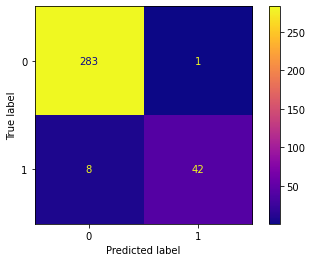

In [7]:
fitted_model = clf.fit(X, y)
Xval = val_df.drop(['churn'], axis='columns')
yval = val_df['churn']
ev.BuildConfusion(clf, Xval, yval)

In [8]:
ev.AUC(clf, Xval, yval)

0.9182394366197183

Whthout ML: -$4,396

With this model: $14,406

# Step 2: normalize the data

Accuracy imporved more from MinMaxScaling but validation recall and AUC dropped significantly. I ended up using standard scaler instead.

In [9]:
scaler = StandardScaler()
ml.PipeIt(scaler, clf, X, y)

'Training: 0.989773232547799, Validation: 0.9533333333333334'

In [10]:
scaler = MinMaxScaler()
ml.PipeIt(scaler, clf, X, y)

'Training: 0.9915518008003558, Validation: 0.9506666666666667'

In [11]:
X = StandardScaler().fit(X).transform(X)
Xval = StandardScaler().fit(Xval).transform(Xval)
ml.CompareClassifiers(X, y)

,Model,train_acc,test_acc
0,KNN,0.903068,0.873333
1,NB,0.875500,0.861333
2,DT,1.000000,0.906667
3,RF,1.000000,0.949333
4,AB,0.898622,0.872000
5,GB,0.975989,0.948000
6,XGB,0.973321,0.945333
7,Log,0.875500,0.858667
8,SVM,0.943086,0.904000


In [12]:
parameters =  {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf = ml.Optimize(XGBClassifier(), parameters, X, y)
clf

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    3.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.9s finished


XGBClassifier(max_depth=6, subsample=0.7)

In [13]:
ev.ScoreModel(clf, X, y)

'Training: 0.989773232547799, Validation: 0.948'

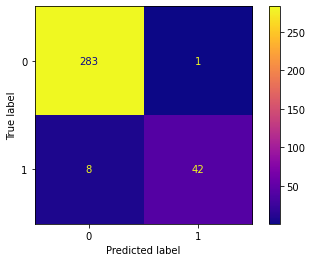

In [14]:
model = clf.fit(X, y)
ev.BuildConfusion(model, Xval, yval)

Whthout ML: -$4,396
    
with this model: $14,406

In [15]:
ev.AUC(clf, Xval, yval)

0.9182394366197183

In [16]:
X3 = pd.DataFrame(SMOTE().fit_resample(X, y)[0])
y3 = SMOTE().fit_resample(X, y)[1]

In [17]:
ml.CompareClassifiers(X3, y3)

,Model,train_acc,test_acc
0,KNN,0.925695,0.872175
1,NB,0.747727,0.711613
2,DT,1.000000,0.918161
3,RF,1.000000,0.959470
4,AB,0.897116,0.894778
5,GB,0.956352,0.947779
6,XGB,0.955053,0.954014
7,Log,0.797870,0.784100
8,SVM,0.925695,0.897896


In [18]:
parameters = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf = ml.Optimize(XGBClassifier(), parameters, X3, y3)
clf

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    5.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.2s finished


XGBClassifier(learning_rate=0.2, max_depth=6, min_child_weight=2, subsample=0.7)

In [19]:
ev.ScoreModel(clf, X3, y3)

'Training: 1.0, Validation: 0.9664848012470771'

In [20]:
fit = clf.fit(X3, y3)

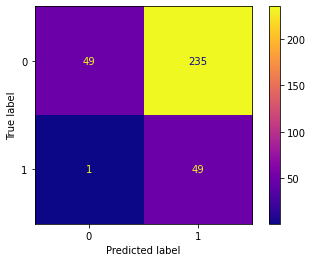

In [24]:
Xval = pd.DataFrame(Xval)
ev.BuildConfusion(clf.fit(X3, y3), Xval, yval)

Without ML: $-4,396

With this model: $14,266

In [25]:
ev.AUC(clf, Xval, yval)

0.5762676056338027

In [26]:
lst = ['international plan',
 'voice mail plan',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 '%night',
 '%eve',
 'avg duration',
 'Midwest',
 'Noncontinental',
 'Northeast',
 'Northwest',
 'Southeast',
 'Southwest']

X3.columns = lst
X3.head()

,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,...,customer service calls,%night,%eve,avg duration,Midwest,Noncontinental,Northeast,Northwest,Southeast,Southwest
0,-0.326561,-0.622207,-0.595562,1.281143,0.869069,1.280871,1.010979,0.945072,1.010003,1.579421,...,-0.436839,-0.967551,0.485003,-1.050496,-0.562588,-0.185727,-0.602646,-0.342582,-0.572858,2.878338
1,-0.326561,1.607182,1.305235,1.169053,1.812314,1.169537,0.703362,0.387803,0.703780,-0.544131,...,-0.436839,0.859822,-1.153179,0.674003,-0.562588,-0.185727,-0.602646,-0.342582,-0.572858,2.878338
2,-0.326561,1.607182,0.574159,-0.628072,-0.620267,-0.628024,-0.199767,1.451681,-0.198653,0.294165,...,-1.198070,-1.150289,1.759144,0.101439,-0.562588,-0.185727,-0.602646,-0.342582,1.745633,-0.347423
3,-0.326561,1.607182,2.182526,-1.375955,-0.719556,-1.376017,-1.564322,1.147716,-1.565062,0.413354,...,-1.198070,0.677085,0.667023,1.938974,-0.562588,-0.185727,1.659350,-0.342582,-0.572858,-0.347423
4,3.062215,-0.622207,-0.595562,0.220877,-0.471333,0.220494,1.083939,0.489125,1.084240,0.059760,...,-0.436839,-0.053865,0.485003,-0.627203,-0.562588,-0.185727,-0.602646,-0.342582,1.745633,-0.347423


# Time for some Feature Engineering

I will test out 5 different feature combos

In [27]:
Xval.columns = list(X3.columns)
Xval

,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,...,customer service calls,%night,%eve,avg duration,Midwest,Noncontinental,Northeast,Northwest,Southeast,Southwest
0,-0.33665,-0.584265,-0.558117,-1.925862,-0.718809,-1.926030,-0.755095,-0.750982,-0.754962,0.706492,...,1.912783,-0.450336,0.206306,-0.109291,-0.565825,-0.123278,-0.575045,-0.404676,1.826927,-0.374075
1,-0.33665,-0.584265,-0.558117,0.424559,0.004641,0.424830,-0.077627,0.185293,-0.078750,1.700308,...,0.404236,0.608906,-0.144362,-0.541423,-0.565825,-0.123278,-0.575045,2.471110,-0.547367,-0.374075
2,-0.33665,-0.584265,-0.558117,-1.101025,-0.408759,-1.100545,-0.431175,0.512989,-0.431960,1.013014,...,-0.350037,-0.097256,0.556975,0.138357,1.767330,-0.123278,-0.575045,-0.404676,-0.547367,-0.374075
3,-0.33665,-0.584265,-0.558117,-2.201416,-0.202059,-2.201907,0.048781,1.308822,0.049056,0.152468,...,-1.104310,-0.626877,1.082978,1.374610,1.767330,-0.123278,-0.575045,-0.404676,-0.547367,-0.374075
4,-0.33665,-0.584265,-0.558117,0.939170,0.521391,0.939013,-2.404325,-0.516913,-2.404826,0.849282,...,-0.350037,0.255825,-0.670365,0.158219,-0.565825,-0.123278,-0.575045,-0.404676,1.826927,-0.374075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,-0.33665,-0.584265,-0.558117,-2.028054,-1.648959,-2.028008,-0.077627,-0.563727,-0.078750,0.647472,...,-0.350037,2.374309,-0.495031,0.506310,-0.565825,-0.123278,1.738993,-0.404676,-0.547367,-0.374075
330,-0.33665,-0.584265,-0.558117,0.504853,1.296517,0.505339,-0.383772,0.700243,-0.383162,0.344758,...,1.158510,-0.803417,0.206306,0.198958,1.767330,-0.123278,-0.575045,-0.404676,-0.547367,-0.374075
331,-0.33665,1.711552,1.842025,-1.500670,-2.114034,-1.500943,2.286598,-0.001962,2.286829,-0.746154,...,1.912783,1.668148,0.556975,-0.456498,-0.565825,-0.123278,1.738993,-0.404676,-0.547367,-0.374075
332,-0.33665,-0.584265,-0.558117,-0.852844,-1.442259,-0.852578,0.945488,0.419361,0.946024,0.832147,...,1.158510,1.315067,0.381641,-0.399108,-0.565825,-0.123278,1.738993,-0.404676,-0.547367,-0.374075


In [28]:
sample1 = X3.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages'], axis='columns')
sv1 = Xval.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages'], axis='columns')
sample2 = X3.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest'], axis='columns')
sv2 = Xval.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest'], axis='columns')
sample3 = X3.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages',
                 'total night charge', 'total night calls', 'total eve charge', 'total eve calls', 'total day charge', 'total day calls'], axis='columns')
sv3 = Xval.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages',
                 'total night charge', 'total night calls', 'total eve charge', 'total eve calls', 'total day charge', 'total day calls'], axis='columns')
sample4 = dh.MakeNewDF(X3, y3, 10)
sv4 = dh.MakeNewDF(Xval, yval, 10)
sample5 = dh.MakeNewDF(X3, y3, 19)
sv5 = dh.MakeNewDF(Xval, yval, 19)

In [29]:
ml.CompareClassifiers(sample1, y3)

,Model,train_acc,test_acc
0,KNN,0.932450,0.888542
1,NB,0.787997,0.764614
2,DT,1.000000,0.921278
3,RF,1.000000,0.945440
4,AB,0.898675,0.862042
5,GB,0.967264,0.939984
6,XGB,0.960769,0.937646
7,Log,0.791634,0.776306
8,SVM,0.918940,0.896337


In [30]:
parameters = {'max_depth': [3, 5, None], 'n_estimators': [50, 100, 200]}
clf = ml.Optimize(GradientBoostingClassifier(), parameters, sample1, y3)
clf

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   21.0s finished


GradientBoostingClassifier(max_depth=5, n_estimators=200)

AUC: 0.579225352112676
Training: 0.9987009612886464, Validation: 0.9641465315666407


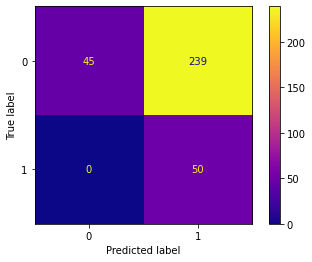

In [31]:
score = ev.ScoreModel(clf, sample1, y3)
fit = clf.fit(sample1, y3)
ev.BuildConfusion(fit, sv1, yval)
print('AUC: {}'.format(ev.AUC(clf, sv1, yval)))
print(score)

Without ML: $-4,396

With this model: $14,658

In [32]:
ml.CompareClassifiers(sample2, y3)

,Model,train_acc,test_acc
0,KNN,0.931151,0.876072
1,NB,0.776046,0.768511
2,DT,1.000000,0.910366
3,RF,1.000000,0.939984
4,AB,0.895557,0.882307
5,GB,0.965965,0.928293
6,XGB,0.961808,0.920499
7,Log,0.797870,0.778644
8,SVM,0.917381,0.882307


In [33]:
parameters = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf = ml.Optimize(XGBClassifier(), parameters, sample3, y3)
clf

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.7s finished


XGBClassifier(learning_rate=0.2, max_depth=6, subsample=0.7)

Training: 0.9989607690309171, Validation: 0.9672642244738893


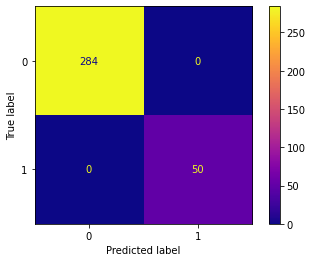

In [35]:
score = ev.ScoreModel(clf, sample3, y3)
fit = clf.fit(sv3, yval)
print(score)
ev.BuildConfusion(fit, sv3, yval)

This ended up being the best model ^^^

Without ML: $-4,396

With this Model: $18,004

In [36]:
ml.CompareClassifiers(sample4, y3)

,Model,train_acc,test_acc
0,KNN,0.919200,0.881528
1,NB,0.771369,0.783320
2,DT,1.000000,0.904910
3,RF,1.000000,0.932190
4,AB,0.889842,0.881528
5,GB,0.943882,0.921278
6,XGB,0.939725,0.919719
7,Log,0.783580,0.793453
8,SVM,0.877631,0.879969


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.5s finished


GradientBoostingClassifier(max_depth=5, n_estimators=200)
Training: 0.9924655754741492, Validation: 0.936087295401403


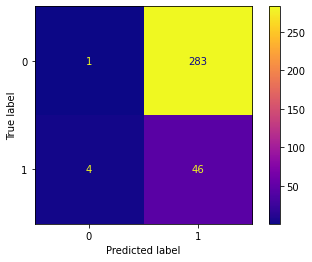

In [37]:
parameters = {'max_depth': [3, 5, None], 'n_estimators': [50, 100, 200]}
clf = ml.Optimize(GradientBoostingClassifier(), parameters, sample4, y3)
print(clf)
score = ev.ScoreModel(clf, sample4, y3)
print(score)
fit = clf.fit(sample4, y3)
#auc = ev.AUC(clf, sample4, y)
#print('AUC: {}'.format(auc))
ev.BuildConfusion(fit, sv4, yval)

Without ML: $-4,396
    
With this model: $12,250

In [38]:
ml.CompareClassifiers(sample5, y3)

,Model,train_acc,test_acc
0,KNN,0.930372,0.900234
1,NB,0.753442,0.759938
2,DT,1.000000,0.915822
3,RF,1.000000,0.948558
4,AB,0.899454,0.891660
5,GB,0.957651,0.946220
6,XGB,0.956872,0.939205
7,Log,0.796051,0.786438
8,SVM,0.924656,0.890881


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.8s finished


GradientBoostingClassifier(max_depth=5, n_estimators=200)
Training: 0.9989607690309171, Validation: 0.9688230709275136


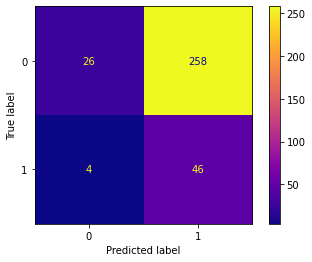

In [39]:
parameters = {'max_depth': [3, 5, None], 'n_estimators': [50, 100, 200]}
clf = ml.Optimize(GradientBoostingClassifier(), parameters, sample5, y3)
print(clf)
score = ev.ScoreModel(clf, sample5, y3)
print(score)
#auc = ev.AUC(clf, sv5, yval)
#print('AUC: {}'.format(auc))
fit = clf.fit(sample5, y3)
ev.BuildConfusion(fit, sv5, yval)

Without ML: $-4,396

With ML: $12,600

In [40]:
yval = pd.DataFrame(np.array(yval))
yval.columns = ['churn']

In [41]:
newdf = pd.concat([sample3, y], axis='columns')
val_df = pd.concat([sv3, yval], axis='columns')

In [42]:
val_df.to_csv('ChurnValidation.csv')

In [43]:
newdf.to_csv('Churn3.csv')

Training: 0.9841517277214861, Validation: 0.9625876851130164


C:\Users\aacjp\Anaconda3\envs\flatiron-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


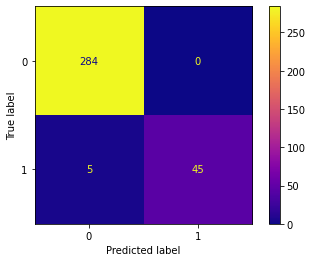

In [44]:
clf = XGBClassifier(max_depth=6, min_child_weight=2, subsample=0.7)

score = ev.ScoreModel(clf, sample3, y3)
#auc = ev.AUC(clf, sample3, y)
fit = clf.fit(sv3, yval)
print(score)
#print('AUC: {}'.format(auc))
ev.BuildConfusion(fit, sv3, yval)

Without ML: $-4,396

With model: $15,764

In [45]:
ev.AUC(clf, sv3, yval)

0.95

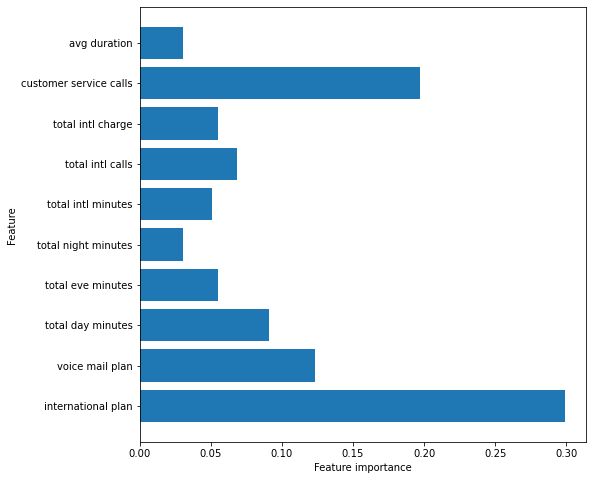

In [46]:
ev.GetImportance(clf, sample3, y3)

## Engineering 3 new features

In [47]:
total_minutes = []
pct_min_intl = []
irreg_calls = []
for i in range(len(sample3)):
    tm = sample3['total day minutes'][i] + sample3['total night minutes'][i] + sample3['total eve minutes'][i] + sample3['total intl minutes'][i]
    total_minutes.append(tm)
    pct_min_intl.append(sample3['total intl minutes'][i] / tm)
    irreg_calls.append(sample3['total intl calls'][i] + sample3['customer service calls'][i])
    
sample3['total minutes'] = total_minutes
sample3['% intl minutes'] = pct_min_intl
sample3['irreg calls'] = irreg_calls

sample3.head()

,international plan,voice mail plan,total day minutes,total eve minutes,total night minutes,total intl minutes,total intl calls,total intl charge,customer service calls,avg duration,total minutes,% intl minutes,irreg calls
0,-0.326561,-0.622207,1.281143,1.010979,1.579421,0.553778,-0.607237,0.558388,-0.436839,-1.050496,4.425321,0.125138,-1.044075
1,-0.326561,1.607182,1.169053,0.703362,-0.544131,-0.446950,1.830652,-0.447644,-0.436839,0.674003,0.881334,-0.507129,1.393813
2,-0.326561,1.607182,-0.628072,-0.199767,0.294165,0.375076,1.018022,0.373067,-1.198070,0.101439,-0.158597,-2.364961,-0.180048
3,-0.326561,1.607182,-1.375955,-1.564322,0.413354,-2.341186,-0.200922,-2.340572,-1.198070,1.938974,-4.868108,0.480923,-1.398992
4,3.062215,-0.622207,0.220877,1.083939,0.059760,1.447285,0.611708,1.445285,-0.436839,-0.627203,2.811861,0.514707,0.174869


In [53]:
total_minutes = []
pct_min_intl = []
irreg_calls = []
for i in range(len(sv3)):
    tm = sv3['total day minutes'][i] + sv3['total night minutes'][i] + sv3['total eve minutes'][i] + sv3['total intl minutes'][i]
    total_minutes.append(tm)
    pct_min_intl.append(sv3['total intl minutes'][i] / tm)
    irreg_calls.append(sv3['total intl calls'][i] + sv3['customer service calls'][i])
    
sv3['total minutes'] = total_minutes
sv3['% intl minutes'] = pct_min_intl
sv3['irreg calls'] = irreg_calls

sv3.head()

,international plan,voice mail plan,total day minutes,total eve minutes,total night minutes,total intl minutes,total intl calls,total intl charge,customer service calls,avg duration,total minutes,% intl minutes,irreg calls
0,-0.33665,-0.584265,-1.925862,-0.755095,0.706492,-0.702894,-0.547802,-0.709093,1.912783,-0.109291,-2.677359,0.262532,1.364981
1,-0.33665,-0.584265,0.424559,-0.077627,1.700308,1.165858,0.267191,1.164210,0.404236,-0.541423,3.213097,0.362845,0.671427
2,-0.33665,-0.584265,-1.101025,-0.431175,1.013014,0.726152,-0.140306,0.729821,-0.350037,0.138357,0.206966,3.508561,-0.490343
3,-0.33665,-0.584265,-2.201416,0.048781,0.152468,0.103234,0.267191,0.105386,-1.104310,1.374610,-1.896932,-0.054422,-0.837120
4,-0.33665,-0.584265,0.939170,-2.404325,0.849282,1.129216,-0.140306,1.123486,-0.350037,0.158219,0.513342,2.199735,-0.490343


In [54]:
df2 = dh.MakeNewDF(sample3, y3, 10)
val2 = sv3[list(df2.columns)]

In [55]:
ml.CompareClassifiers(df2, y3)

,Model,train_acc,test_acc
0,KNN,0.920499,0.886204
1,NB,0.791634,0.785659
2,DT,1.000000,0.911925
3,RF,1.000000,0.947779
4,AB,0.886204,0.875292
5,GB,0.957132,0.948558
6,XGB,0.956092,0.949337
7,Log,0.786438,0.763835
8,SVM,0.903092,0.887763


In [56]:
parameters = {'min_samples_leaf': [0.5, 1, 2]}
clf = ml.Optimize(GradientBoostingClassifier(max_depth=6, n_estimators=200), parameters, df2, y3)
score = ev.ScoreModel(clf, df2, y3)
print(clf)
print(score)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.1s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.3s finished


GradientBoostingClassifier(max_depth=6, n_estimators=200)
Training: 1.0, Validation: 0.9469992205767732


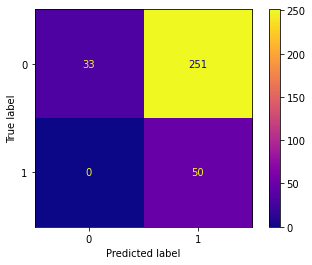

In [57]:
clf = GradientBoostingClassifier(max_depth=6, n_estimators=200)
ev.BuildConfusion(clf.fit(df2, y3), val2, yval)

We have 100% recall, But way too many false positives!

Without ML: -$4,396
    
With this model: $14,490